In [12]:
from __future__ import print_function
from rdkit.Chem.Draw import IPythonConsole, ReactionToImage, MolToImage
import pandas as pd
import numpy as np
import json
import sys
sys.path.append('../../')
from retrosim.utils.draw import ReactionStringToImage, TransformStringToImage
from retrosim.utils.generate_retro_templates import process_an_example
from retrosim.data.get_data import get_data_df, split_data_df

In [13]:
data = get_data_df('../data/data_processed.csv')
split_data_df(data) # 80/10/10 within each class

15151 rows with class value 1
11896 rows with class value 2
5662 rows with class value 3
909 rows with class value 4
672 rows with class value 5
8237 rows with class value 6
4614 rows with class value 7
811 rows with class value 8
1834 rows with class value 9
230 rows with class value 10
train    40008
test      5007
val       5001
Name: dataset, dtype: int64


O=C(OCc1ccccc1)[NH:1][CH2:2][CH2:3][CH2:4][CH2:5][C@@H:6]([C:7]([O:8][CH3:9])=[O:10])[NH:11][C:12](=[O:13])[NH:14][c:15]1[cH:16][c:17]([O:18][CH3:19])[cH:20][c:21]([C:22]([CH3:23])([CH3:24])[CH3:25])[c:26]1[OH:27]>>[NH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C@@H:6]([C:7]([O:8][CH3:9])=[O:10])[NH:11][C:12](=[O:13])[NH:14][c:15]1[cH:16][c:17]([O:18][CH3:19])[cH:20][c:21]([C:22]([CH3:23])([CH3:24])[CH3:25])[c:26]1[OH:27]


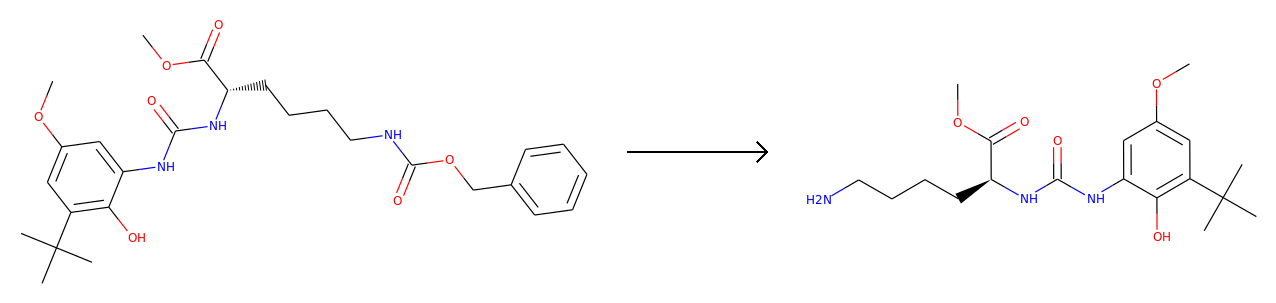

In [14]:
print(data['rxn_smiles'][0])
ReactionStringToImage(data['rxn_smiles'][0])

In [15]:
from joblib import Parallel, delayed
import multiprocessing

def extract_one_template(reaction_smiles):
    retro_canonical = process_an_example(reaction_smiles, super_general=True)
    if retro_canonical is None:
        return None
    return '({})>>{}'.format(retro_canonical.split('>>')[0], retro_canonical.split('>>')[1])
    
inputs = list(data.loc[data['dataset']=='train']['rxn_smiles'])
num_cores = multiprocessing.cpu_count()
all_retro_canonical_uni = Parallel(n_jobs=num_cores, verbose=3)(delayed(extract_one_template)(i) for i in inputs)

templates = {}
for retro_canonical_uni in all_retro_canonical_uni:
    if retro_canonical_uni in templates:
        templates[retro_canonical_uni] += 1
    else:
        templates[retro_canonical_uni] = 1

[Parallel(n_jobs=32)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=32)]: Done 1664 tasks      | elapsed:    2.1s
[Parallel(n_jobs=32)]: Done 3904 tasks      | elapsed:    4.4s
[Parallel(n_jobs=32)]: Done 6784 tasks      | elapsed:    7.6s
[Parallel(n_jobs=32)]: Done 10304 tasks      | elapsed:   11.4s
[Parallel(n_jobs=32)]: Done 14464 tasks      | elapsed:   16.0s
[Parallel(n_jobs=32)]: Done 19264 tasks      | elapsed:   21.2s
[Parallel(n_jobs=32)]: Done 24704 tasks      | elapsed:   27.1s
[Parallel(n_jobs=32)]: Done 30784 tasks      | elapsed:   33.9s
[Parallel(n_jobs=32)]: Done 37504 tasks      | elapsed:   41.1s
[Parallel(n_jobs=32)]: Done 40008 out of 40008 | elapsed:   43.7s finished


In [16]:
with open('../data/templates_general.json', 'wb') as fid:
    json.dump(templates, fid, indent=4)

In [17]:
for template, count in sorted(templates.iteritems(), 
                              key=lambda x: x[1], reverse=True)[:50]:
    print('{}     {}'.format(count, template))

2875     ([C;H0;+0:1]-[NH;+0:2])>>O-[C;H0;+0:1].[NH2;+0:2]
1797     ([OH;+0:1])>>C-[O;H0;+0:1]
1322     ([C;H0;+0:1]-[N;H0;+0:2])>>O-[C;H0;+0:1].[NH;+0:2]
1277     ([NH2;+0:1])>>O=[N+;H0:1]-[O-]
1213     ([NH;+0:1]-[c;H0;+0:2])>>Cl-[c;H0;+0:2].[NH2;+0:1]
1149     ([C;H0;+0:1]-[NH;+0:2])>>Cl-[C;H0;+0:1].[NH2;+0:2]
1123     ([OH;+0:1])>>C-C-[O;H0;+0:1]
860     ([NH;+0:1])>>C-C(-C)(-C)-O-C(=O)-[N;H0;+0:1]
830     ([CH2;+0:1]-[O;H0;+0:2])>>Br-[CH2;+0:1].[OH;+0:2]
706     ([C;H0;+0:1]-[N;H0;+0:2])>>Cl-[C;H0;+0:1].[NH;+0:2]
664     ([CH2;+0:1]-[N;H0;+0:2])>>Br-[CH2;+0:1].[NH;+0:2]
648     ([N;H0;+0:1]-[c;H0;+0:2])>>Cl-[c;H0;+0:2].[NH;+0:1]
621     ([NH2;+0:1])>>C-C(-C)(-C)-O-C(=O)-[NH;+0:1]
549     ([NH;+0:1]-[S;H0;+0:2])>>Cl-[S;H0;+0:2].[NH2;+0:1]
524     ([c;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:1].O-B(-O)-[c;H0;+0:2]
517     ([CH2;+0:1]-[N;H0;+0:2])>>Cl-[CH2;+0:1].[NH;+0:2]
474     ([CH2;+0:1]-[O;H0;+0:2])>>O-[CH2;+0:1].[OH;+0:2]
452     ([O;H0;+0:1]-[c;H0;+0:2])>>Cl-[c;H0;+0:2].[OH;+0:1]
44

In [9]:
sum([count == 1 for count in templates.values()])

567

In [10]:
len(templates)

1351

## Testing self-specificity

In [19]:
import rdkit.Chem as Chem

def test_one(reaction_smiles):
    retro_canonical = extract_one_template(reaction_smiles)
    if retro_canonical is None:
        return -1
    product = Chem.MolFromSmiles(reaction_smiles.split('>')[-1])
    pattern = Chem.MolFromSmarts(retro_canonical[1:].split(')>>')[0])
    matches = set(frozenset(x) for x in product.GetSubstructMatches(pattern))
    return len(matches)

inputs = data.loc[data['dataset']=='train']['rxn_smiles']
num_matches = Parallel(n_jobs=num_cores, verbose=3)(delayed(test_one)(i) for i in inputs)

[Parallel(n_jobs=32)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=32)]: Done 2304 tasks      | elapsed:    2.7s
[Parallel(n_jobs=32)]: Done 5440 tasks      | elapsed:    6.0s
[Parallel(n_jobs=32)]: Done 9472 tasks      | elapsed:   10.2s
[Parallel(n_jobs=32)]: Done 14400 tasks      | elapsed:   15.3s
[Parallel(n_jobs=32)]: Done 20224 tasks      | elapsed:   21.7s
[Parallel(n_jobs=32)]: Done 26944 tasks      | elapsed:   29.0s
[Parallel(n_jobs=32)]: Done 34560 tasks      | elapsed:   37.2s
[Parallel(n_jobs=32)]: Done 40008 out of 40008 | elapsed:   43.0s finished


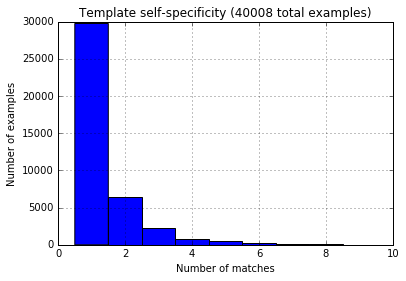

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.DataFrame({'pop': num_matches})
plot = df['pop'].hist(bins=[x+0.5 for x in range(10)])
plot.set_title("Template self-specificity ({} total examples)".format(len(num_matches)))
plot.set_xlabel("Number of matches")
plot.set_ylabel("Number of examples")